# Ring Resonator Behaviour

Here, we test the gap dependence of the transmitted field in the ring.

In [1]:
# Import packages 

import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
import scipy.optimize as sp

In [2]:
# General Parameters 

n = 1.7
w = 0.5
r = 2
gap = 0.1 # From 0.1 to 0.4 is fine
guide_w = 0.5


fcen = 0.663 # Center of frequency range
df = 0.4 # width of source

leftpad = 10
rightpad = 8
bottompad = 1
toppad = 1
dpml = 1

resolution = 16

int_lim = 1e-3 # threshold for decay

src_width = 0.8 * guide_w # Source width

silicon = mp.Medium(epsilon = n**2) # Guide medium

# Frequency vector

nfreq = 2000

f_step = df/nfreq

fmin = fcen - f_step*(nfreq/2)
fmax = fcen + f_step*(nfreq/2)

fvec = np.linspace(fmin, fmax, nfreq)

c = 2.99792548 *1e8 # Speed of light 
a = 5 * 1e-6 # We fix this length scale, 5 microns. Corresponds to real world integrated device size
courant = 0.5 

fvec_SI = fvec * (c*courant*resolution) / a # frequency vector in SI

fvec_SI = fvec_SI / 1e12 # To have it in THz

-----------
Initializing structure...
time for choose_chunkdivision = 0.000123978 s
Working in 2D dimensions.
Computational cell is 25 x 10 x 0 with resolution 16
     block, center = (0,-2.85,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.105804 s
-----------
field decay(t = 50.03125): 7.93965373687554e-06 / 7.93965373687554e-06 = 1.0
field decay(t = 100.0625): 3.323104182622651e-13 / 7.93965373687554e-06 = 4.185452278842552e-08
run 0 finished at t = 100.0625 (3202 timesteps)


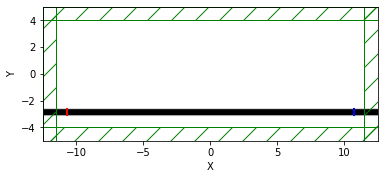

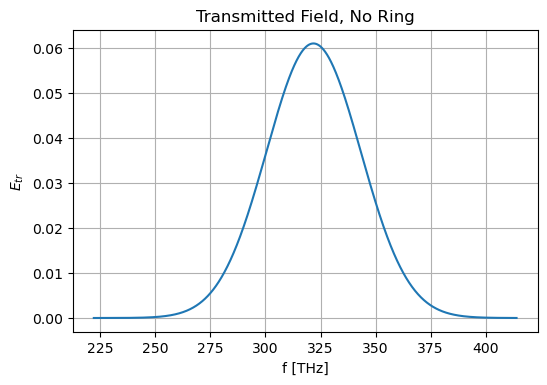

In [3]:
# Geometry with straight wg for normalisation spectrum.

# cell size

sx = np.ceil(leftpad + rightpad + 2 * (r + w) + 2 * dpml )
sy = np.ceil(toppad + bottompad +  2 * (r + w) + 2 * dpml + guide_w + gap)

# geometry 

guide_cent_x = 0
guide_cent_y = -(r+w+gap+guide_w/2)

straight_guide = mp.Block( mp.Vector3(mp.inf, guide_w, mp.inf), 
                           center = mp.Vector3(guide_cent_x, guide_cent_y,0),  
                           material = mp.Medium(index = n)) 

# Gaussian Source for normalisation spectrum 

src = mp.Source(mp.GaussianSource(fcen, fwidth = df),
               mp.Ez,
               center = mp.Vector3(-(sx/2 - dpml - 0.8), guide_cent_y, 0),
               size = mp.Vector3(0,src_width,0))

# Simulation

sim = mp.Simulation(cell_size = mp.Vector3(sx,sy),
                   geometry = [straight_guide],
                   sources = [src],
                   resolution = resolution,
                   boundary_layers = [mp.PML(dpml)])

# Now define monitor for transmitted field, will be the same later as well

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 0.8, guide_cent_y, 0), size = mp.Vector3(0,guide_w,0) )
trans = sim.add_flux(fcen, df, nfreq, tr_fr)

# Geometry Plot 

sim.plot2D()

# Now, run the simulation ang get transmitted field spectrum

# We do a simulation with a gaussian source and just the straight guide and monitor the transmitted field

# Run Simulation

pt = mp.Vector3(sx/2 - dpml - 0.8,guide_w,0)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, int_lim)) 

# Now Get Flux

straight_tr_fl_0 = mp.get_fluxes(trans)
fl_tr = mp.get_flux_freqs(trans)

straight_tr_data = sim.get_flux_data(trans)

# Print out spectrum at monitor

fl_tr_SI = np.array(fl_tr) * (c*courant*resolution) / (a*1e12) 

fig = plt.figure(dpi=100)

plt.plot(fl_tr_SI, np.abs(straight_tr_fl_0), label="Transmitted")
plt.title("Transmitted Field, No Ring")
plt.xlabel("f [THz]")
plt.ylabel(r"$E_{tr}$")
plt.grid()
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000138044 s
Working in 2D dimensions.
Computational cell is 25 x 10 x 0 with resolution 16
     block, center = (0,-2.85,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.156073 s
-----------


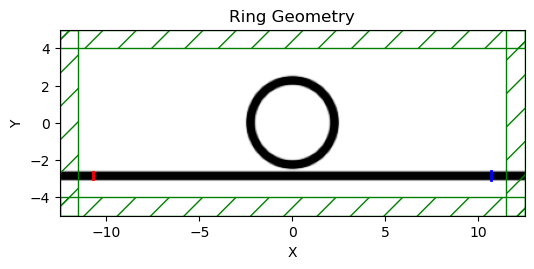

In [4]:
# Define geometry of rings

ext_ring = mp.Cylinder(radius = r+w, center=mp.Vector3(0,0), material = silicon)
int_ring = mp.Cylinder(radius = r, center=mp.Vector3(0,0), material = mp.Medium(epsilon = 1.00))

geometry = [straight_guide, ext_ring, int_ring]

# Now, reset MEEP 

sim.reset_meep()

# Define New Simulation

sim = mp.Simulation(cell_size = mp.Vector3(sx,sy),
                   geometry = geometry,
                   sources = [src],
                   resolution = resolution,
                   boundary_layers = [mp.PML(dpml)])

# Now define monitor for transmitted field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 0.8, guide_cent_y, 0), size = mp.Vector3(0,guide_w,0) )
trans = sim.add_flux(fcen, df, nfreq, tr_fr)

# Plot geometry

fig = plt.figure(dpi = 100)
sim.plot2D()
plt.title("Ring Geometry")
plt.savefig("ring_geometry.png", dpi = 150, format = "png")

field decay(t = 50.03125): 0.024204577379900845 / 0.024204577379900845 = 1.0
field decay(t = 100.0625): 0.011099164145232088 / 0.024204577379900845 = 0.45855641150126775
field decay(t = 150.09375): 0.0026105359686095296 / 0.024204577379900845 = 0.10785298696341972
field decay(t = 200.125): 0.0006686152059118404 / 0.024204577379900845 = 0.027623502588690084
field decay(t = 250.15625): 0.0001836534805092427 / 0.024204577379900845 = 0.007587551628219962
field decay(t = 300.1875): 5.4494792297320345e-05 / 0.024204577379900845 = 0.0022514250689860044
field decay(t = 350.21875): 1.6941151675230443e-05 / 0.024204577379900845 = 0.000699915202374
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.5450460605580175, -0.0047837337538597854, 56.9686868670569, 0.004388513139339293, 0.003544052093905387-0.0025881928695208277i, 2.873040509438626e-05+0.0i
harminv0:, 0.5851944234637776, -0.0037498388318575678, 78.02927668412461, 0.011333978775758478, -0.009735335141977287+0.00580

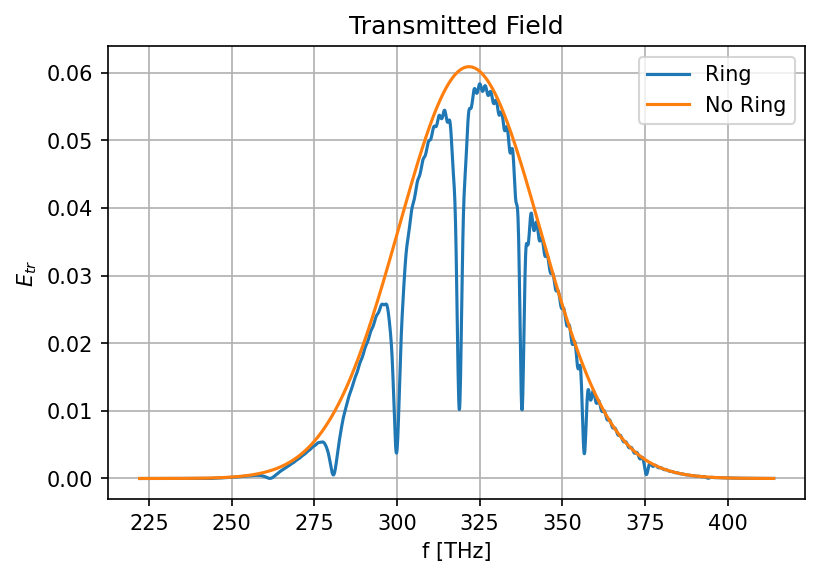

In [5]:
# What happens if we do not load minus sign transmission data for normalisation?
# We will see the whole gaussian field is transmitted (as expected, since it can not survive in the ring)
# The modes that survive in the ring are transmitted as well, since in the end the ring recouples them to the waveguide.
# However, their intensity is smaller because the experience losses in the ring.

# Harminv function

pt = mp.Vector3(r + w/2, 0) # A point inside the ring

har = mp.Harminv(mp.Ez, pt, fcen, df)  # Performs harminv on the field in the ring after the source to find the modes that survived in there and their width

# Run simulation again

sim.run(mp.after_sources(har), until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, int_lim)) 

# Get Flux

straight_tr_fl = mp.get_fluxes(trans)
fl_tr = mp.get_flux_freqs(trans)

# Print out spectrum at monitor

fig = plt.figure(dpi=150)

plt.plot(fl_tr_SI, np.abs(straight_tr_fl), label="Ring")
plt.plot(fl_tr_SI, np.abs(straight_tr_fl_0), label="No Ring")
plt.xlabel("f [THz]")
plt.ylabel(r"$E_{tr}$")
plt.title("Transmitted Field")
plt.legend()
plt.grid()
plt.savefig("Transmission_ring_over.png", dpi = 150, format = "png")
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000316858 s
Working in 2D dimensions.
Computational cell is 25 x 10 x 0 with resolution 16
     block, center = (0,-2.85,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.155235 s
-----------
field decay(t = 50.03125): 0.024204577379900845 / 0.024204577379900845 = 1.0
field decay(t = 100.0625): 0.011099164145232088 / 0.024204577379900845 = 0.45855641150126775
field decay(t = 150.09375): 0.0026105359686095296 / 0.024204577379900845 = 0.10785298696341972
field decay(t = 200.125): 0.0006686152059118404 / 0.02420457737990

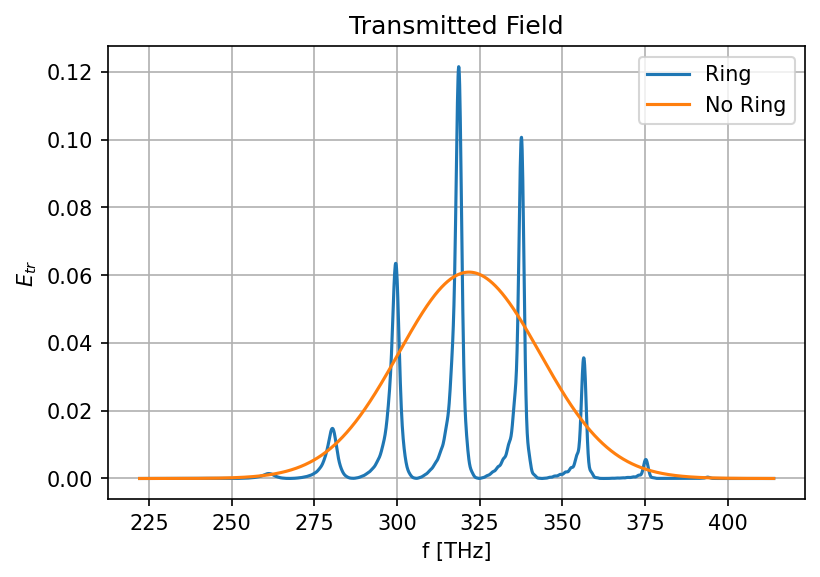

In [6]:
# Now simulate with normalisation 

sim.reset_meep()

# Redefine monitor and redefine simulation if the simulation is reset

sim = mp.Simulation(cell_size = mp.Vector3(sx,sy),
                   geometry = geometry,
                   sources = [src],
                   resolution = resolution,
                   boundary_layers = [mp.PML(dpml)])

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 0.8, guide_cent_y, 0), size = mp.Vector3(0,guide_w,0) )
trans = sim.add_flux(fcen, df, nfreq, tr_fr)

# Harminv function

pt = mp.Vector3(r + w/2, 0) # A point inside the ring

har = mp.Harminv(mp.Ez, pt, fcen, df)  

# Load minus sign transmission data. In this way, we filter away all the transmitted gaussian field and see only the peaks due to the modes 

sim.load_minus_flux_data(trans, straight_tr_data)

# Run simulation again

sim.run(mp.after_sources(har), until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, int_lim)) 

# Get Flux

straight_tr_fl = mp.get_fluxes(trans)
fl_tr = mp.get_flux_freqs(trans)


# Print out spectrum at monitor

fig = plt.figure(dpi=150)

plt.plot(fl_tr_SI, np.abs(straight_tr_fl), label="Ring")
plt.plot(fl_tr_SI, np.abs(straight_tr_fl_0), label="No Ring")
plt.xlabel("f [THz]")
plt.ylabel(r"$E_{tr}$")
plt.title("Transmitted Field")
plt.legend()
plt.grid()
plt.savefig("Transmission_ring_over_normal.png", dpi = 150, format = "png")
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000170946 s
Working in 2D dimensions.
Computational cell is 25 x 10 x 0 with resolution 16
     block, center = (0,-2.85,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.153511 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 215.1875/600.0 = 35.9% done in 4.0s, 7.2s to go
on time step 6894 (time=215.438), 0.000580337 s/step
Meep progress: 440.71875/600.0 = 73.5% done in 8.0s, 2.9s to go
on time step 14116 (time=441.125), 0.000553915 s/step
run 0 finished at t = 600.0 (19200 timesteps)


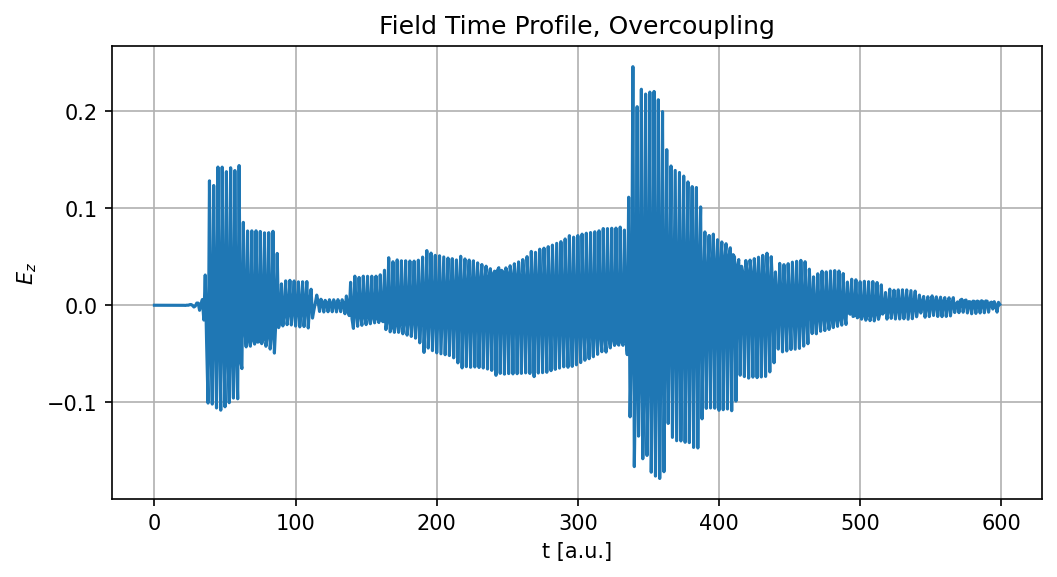

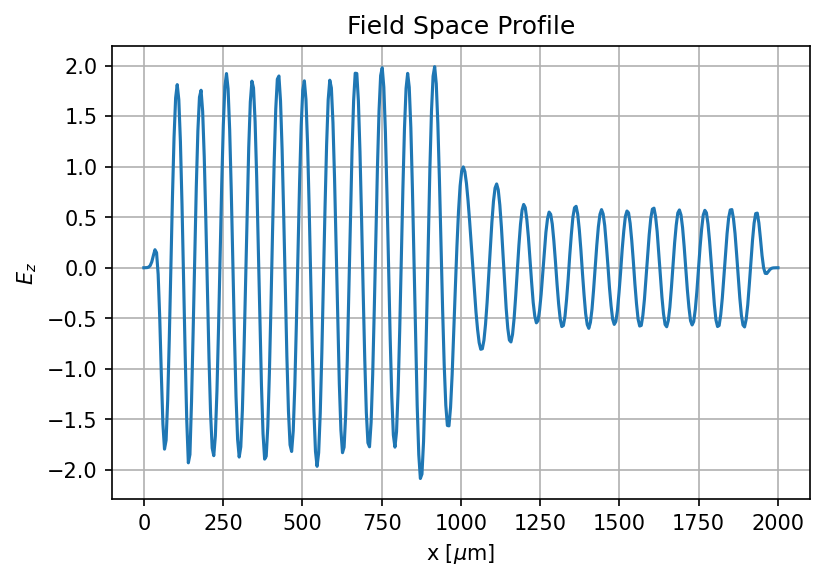

In [7]:
# Ok, very good. So far, you understand what is going on with this simulation. Now, you set a given frequency and prepare the analysis of the signal.
# Now we study what happens if the source is swithced off after some time

# First, we want to get the frequency to set the frequency for the continuous source 

fmax = har.modes[3].freq

# Now, we are ready to setup a new simulation with a continuous source 

# reset MEEP 

sim.reset_meep()

# Make new source 

contsrc = mp.Source(mp.ContinuousSource(frequency = fmax, end_time = 300),
               mp.Ez,
               center = mp.Vector3(-(sx/2 - dpml - 0.8), guide_cent_y, 0),
               size = mp.Vector3(0,src_width,0))

# Define New Simulation

sim = mp.Simulation(cell_size = mp.Vector3(sx,sy),
                   geometry = geometry,
                   sources = [contsrc],
                   resolution = resolution,
                   boundary_layers = [mp.PML(dpml)])

# Now define monitor for transmitted field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 0.8, guide_cent_y, 0), size = mp.Vector3(0,guide_w,0) )
trans = sim.add_flux(fcen, df, nfreq, tr_fr)

# Define a get slice function that gives you the field 

Ez_timeprofile = []
Ez_long_profile = []

def get_slice(sim):
    Ez_timeprofile.append(sim.get_array(center=mp.Vector3(sx/2 - dpml - 0.8, guide_cent_y, 0), size = mp.Vector3(0,guide_w,0), component = mp.Ez))
    
def get_long_slice(sim):
    Ez_long_profile.append(sim.get_array(center=mp.Vector3(0, guide_cent_y, 0), size = mp.Vector3(sx,guide_w,0), component = mp.Ez))


# Run simulation, running a get slice every 10 timesteps

sim.run(mp.at_every(1, get_slice),
        mp.at_time(200, get_long_slice),
        until = 600)

# Now plot the time profile and the full profile after shutdown 

Ez_tm = np.array(Ez_timeprofile) 
Ez_tm = np.trapz(Ez_tm, axis=1) / np.shape(Ez_tm)[1]

fig = plt.figure(figsize=(8,4),dpi = 150)
plt.plot(Ez_tm)
plt.title("Field Time Profile, Overcoupling")
plt.xlabel("t [a.u.]")
plt.ylabel(r"$E_z$")
plt.grid()
plt.savefig("field_profile_time_over.png", dpi = 150, format = "png")
plt.show()

# Integrate the field over the y axis in the waveguide and plot the space profile

Ep = np.array(Ez_long_profile)
Ep = np.trapz(Ep, axis=2)[0]

spacevec = np.linspace(0,400,len(Ep)) * a *1e6

fig = plt.figure(dpi = 150)
plt.plot(spacevec, Ep)
plt.title("Field Space Profile")
plt.xlabel(r"x [$\mu$m]")
plt.ylabel(r"$E_z$")
plt.grid()
plt.savefig("field_long_profile_over.png", dpi = 150, format = "png")
plt.show()



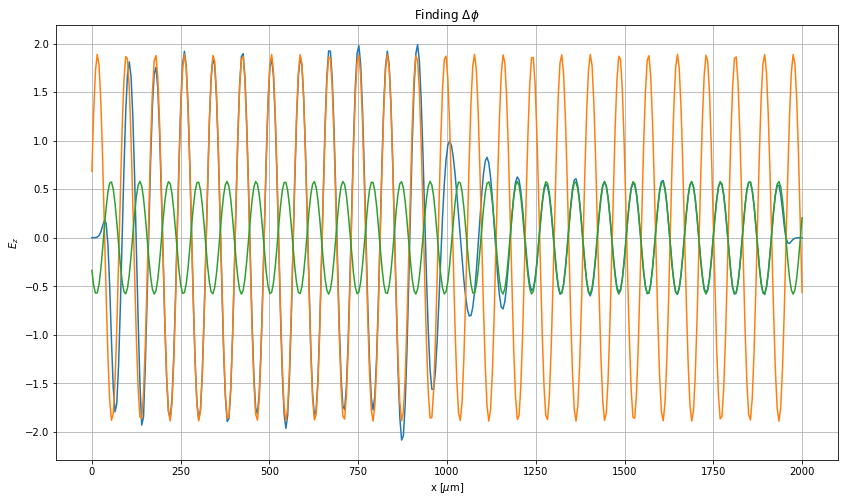

THE PHASESHIFT IS 1.0792849038520598


In [8]:
# So far, so good. Now the fit to the sinusoidal functions in the 2 regions 

x = np.linspace(0,sx*resolution,int(sx*resolution))

def fit_sin(tt, yy, phaseguess):
    '''Fit sin to np arrays, and return parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, phaseguess, guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c

    popt, pcov = sp.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

res1 = fit_sin(x[50:175], Ep[50:175], 0.0)
res2 = fit_sin(x[250:380], Ep[250:380], res1["phase"]+np.pi)

# make figure

fig = plt.figure(figsize=(14,8))
plt.plot(spacevec, Ep)
plt.plot(spacevec, res1["amp"] * np.sin(res1["omega"]*x+res1["phase"]))
plt.plot(spacevec, res2["amp"] * np.sin(res2["omega"]*x+res2["phase"]))
plt.title(r"Finding $\Delta\phi$")
plt.xlabel(r"x [$\mu$m]")
plt.ylabel(r"$E_z$")
plt.grid()
plt.savefig("fit_finding_phaseshift_over_stationary.png", dpi = 150, format = "png")
plt.show()

# And print the phaseshift

print("THE PHASESHIFT IS", abs(res2["phase"]- res1["phase"]) /np.pi)

Ep_old = Ep


In [10]:
res1

{'amp': 1.8897426220779567,
 'omega': 0.38468030514203033,
 'phase': 0.3693791110462676,
 'offset': 0.020330787830875417,
 'freq': 0.061223772073452774,
 'period': 16.333524807982386,
 'fitfunc': <function __main__.fit_sin.<locals>.<lambda>(t)>,
 'maxcov': 0.00020005400646661993,
 'rawres': (array([1.90316934, 0.40111855, 0.        , 0.04795442]),
  array([1.88974262, 0.38468031, 0.36937911, 0.02033079]),
  array([[ 6.35314885e-05, -1.10320622e-08,  7.33095299e-07,
          -9.72143637e-07],
         [-1.10320622e-08,  1.43142884e-08, -1.61310338e-06,
           1.56920029e-08],
         [ 7.33095299e-07, -1.61310338e-06,  2.00054006e-04,
          -6.33002206e-07],
         [-9.72143637e-07,  1.56920029e-08, -6.33002206e-07,
           3.22393641e-05]]))}

In [11]:
res2

{'amp': -0.1221861564953965,
 'omega': 0.38440447253450455,
 'phase': 9.148351463708376,
 'offset': 0.00016224418259650988,
 'freq': 0.06117987195049912,
 'period': 16.34524506375404,
 'fitfunc': <function __main__.fit_sin.<locals>.<lambda>(t)>,
 'maxcov': 0.005225529776419321,
 'rawres': (array([ 1.22124168e-01,  3.98839467e-01,  3.51097176e+00, -3.05381354e-03]),
  array([-1.22186156e-01,  3.84404473e-01,  9.14835146e+00,  1.62244183e-04]),
  array([[ 7.53106096e-07,  4.82043826e-10, -4.56677250e-09,
          -2.03082729e-08],
         [ 4.82043826e-10,  4.89257006e-08, -1.59128920e-05,
          -8.92078396e-09],
         [-4.56677250e-09, -1.59128920e-05,  5.22552978e-03,
           2.76692839e-06],
         [-2.03082729e-08, -8.92078396e-09,  2.76692839e-06,
           3.76449179e-07]]))}

# Now, the phase in the disharge regime

-----------
Initializing structure...
time for choose_chunkdivision = 0.000142097 s
Working in 2D dimensions.
Computational cell is 25 x 10 x 0 with resolution 16
     block, center = (0,-2.85,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.160054 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 230.125/600.0 = 38.4% done in 4.0s, 6.4s to go
on time step 7379 (time=230.594), 0.000542114 s/step
Meep progress: 466.0625/600.0 = 77.7% done in 8.0s, 2.3s to go
on time step 14931 (time=466.594), 0.000529674 s/step
run 0 finished at t = 600.0 (19200 timesteps)


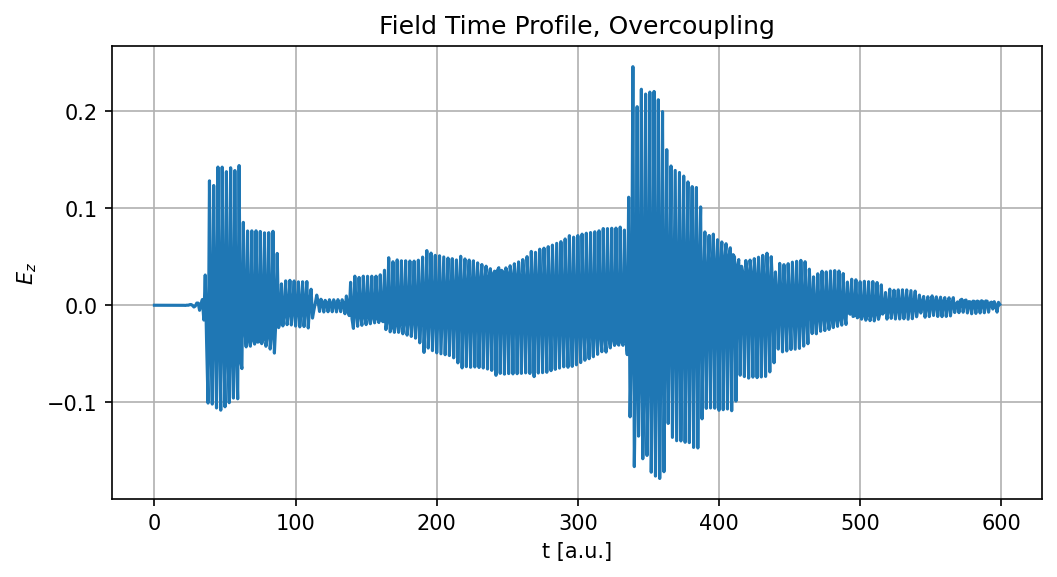

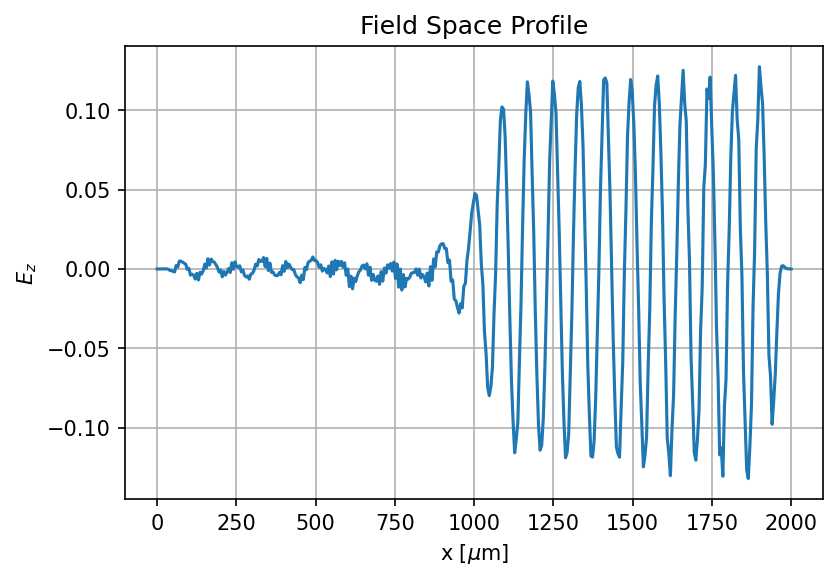

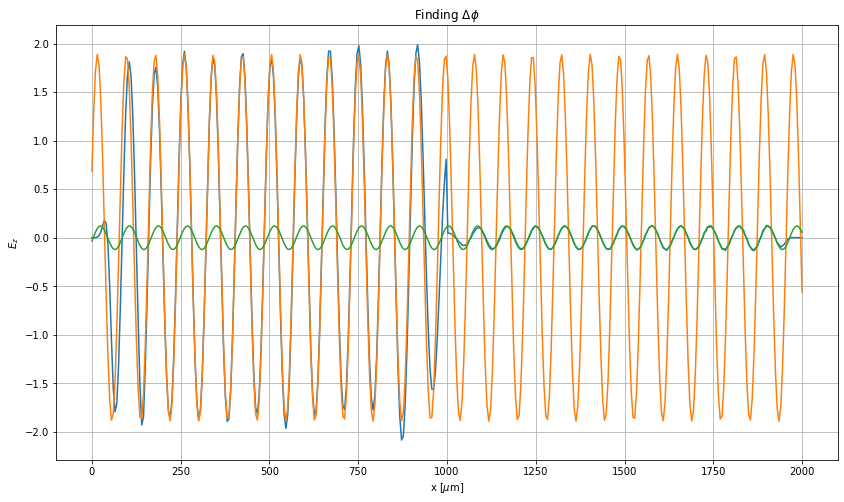

THE PHASESHIFT IS 2.794433690386521


In [9]:
# reset MEEP 

sim.reset_meep()

# Make new source 

contsrc = mp.Source(mp.ContinuousSource(frequency = fmax, end_time = 300),
               mp.Ez,
               center = mp.Vector3(-(sx/2 - dpml - 0.8), guide_cent_y, 0),
               size = mp.Vector3(0,src_width,0))

# Define New Simulation

sim = mp.Simulation(cell_size = mp.Vector3(sx,sy),
                   geometry = geometry,
                   sources = [contsrc],
                   resolution = resolution,
                   boundary_layers = [mp.PML(dpml)])

# Now define monitor for transmitted field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 0.8, guide_cent_y, 0), size = mp.Vector3(0,guide_w,0) )
trans = sim.add_flux(fcen, df, nfreq, tr_fr)

# Define a get slice function that gives you the field 

Ez_timeprofile = []
Ez_long_profile = []


# Run simulation, running a get slice every 10 timesteps

sim.run(mp.at_every(1, get_slice),
        mp.at_time(550, get_long_slice),
        until = 600)

# Now plot the time profile and the full profile after shutdown 

Ez_tm = np.array(Ez_timeprofile) 
Ez_tm = np.trapz(Ez_tm, axis=1) / np.shape(Ez_tm)[1]

fig = plt.figure(figsize=(8,4),dpi = 150)
plt.plot(Ez_tm)
plt.title("Field Time Profile, Overcoupling")
plt.xlabel("t [a.u.]")
plt.ylabel(r"$E_z$")
plt.grid()
plt.show()

# Integrate the field over the y axis in the waveguide and plot the space profile

Ep = np.array(Ez_long_profile)
Ep = np.trapz(Ep, axis=2)[0]

spacevec = np.linspace(0,400,len(Ep)) * a *1e6

fig = plt.figure(dpi = 150)
plt.plot(spacevec, Ep)
plt.title("Field Space Profile")
plt.xlabel(r"x [$\mu$m]")
plt.ylabel(r"$E_z$")
plt.grid()
plt.show()

Ep = np.concatenate((Ep_old[0:200], Ep[200:400]), axis = 0)

# So far, so good. Now the fit to the sinusoidal functions in the 2 regions 

x = np.linspace(0,sx*resolution,int(sx*resolution))

res1 = fit_sin(x[50:175], Ep[50:175], 0.0)
res2 = fit_sin(x[270:380], Ep[270:380], res1["phase"] + np. pi)

# make figure

fig = plt.figure(figsize=(14,8))
plt.plot(spacevec, Ep)
plt.plot(spacevec, res1["amp"] * np.sin(res1["omega"]*x+res1["phase"]))
plt.plot(spacevec, res2["amp"] * np.sin(res2["omega"]*x+res2["phase"]))
plt.title(r"Finding $\Delta\phi$")
plt.xlabel(r"x [$\mu$m]")
plt.ylabel(r"$E_z$")
plt.grid()
plt.savefig("fit_finding_phaseshift_over_disharge.png", dpi = 150, format = "png")
plt.show()

# And print the phaseshift

print("THE PHASESHIFT IS", abs(res2["phase"]- res1["phase"]) /np.pi)


# Overcoupling is observed to stop at approximately 0.17 gap

In [13]:
2.794 / np.pi

0.8893578219975112